# Overview and Examples

A brief description of what linearsolve is for followed by examples.


## What linearsolve Does

linearsolve defines a class - linearsolve.model - with several functions for approximating, solving, and simulating dynamic stochastic general equilibrium (DSGE) models. The equilibrium conditions for most DSGE models can be expressed as a vector function $f$:

\begin{align}
f(E_t X_{t+1}, X_t, \epsilon_{t+1}) = 0,
\end{align}

where 0 is an $n\times 1$ vector of zeros, $X_t$ is an $n\times 1$ vector of endogenous variables, and $\epsilon_{t+1}$ is an $m\times 1$ vector of exogenous structural shocks to the model. $E_tX_{t+1}$ denotes the expecation of the $t+1$ endogenous variables based on the information available to agents in the model as of time period $t$. 


linearsolve.model has methods for computing linear and log-linear approximations of the model given above and methods for solving and simulating the linear model.

## Example 1: Quickly Simulate an RBC Model

Here I demonstrate how how relatively straightforward it is to appoximate, solve, and simulate a DSGE model using `linearsolve`. In the example that follows, I describe the procedure more carefully.

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha A_{t+1} K_{t+1}^{\alpha-1} + 1 - \delta)\right]\\
C_t + K_{t+1} & = A_t K_t^{\alpha} + (1-\delta)K_t\\
\log A_{t+1} & = \rho_a \log A_{t} + \epsilon_{t+1}
\end{align}

In the block of code that immediately follows, I input the model, solve for the steady state, compute the log-linear approximation of the equilibirum conditions, and compute some impulse responses following a shock to technology $A_t$.

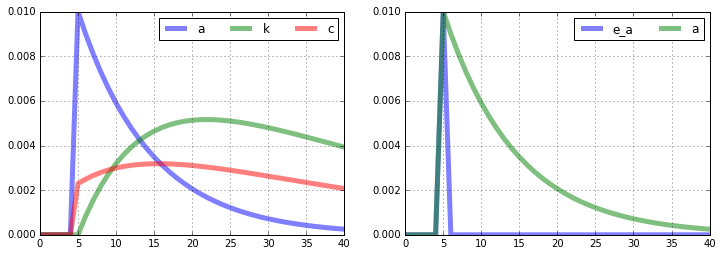

In [1]:
# Import numpy, pandas, linearsolve, matplotlib.pyplot
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Input model parameters
parameters = pd.Series(dtype=float)
parameters['alpha']  = .35
parameters['beta']  = 0.99
parameters['delta']   = 0.025
parameters['rhoa'] = .9
parameters['sigma'] = 1.5
parameters['A'] = 1

# Funtion that evaluates the equilibrium conditions
def equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Household Euler equation
    euler_eqn = p.beta*fwd.c**-p.sigma*(p.alpha*fwd.a*fwd.k**(p.alpha-1)+1-p.delta) - cur.c**-p.sigma
    
    # Goods market clearing
    market_clearing = cur.c + fwd.k - (1-p.delta)*cur.k - cur.a*cur.k**p.alpha
        
    # Exogenous technology
    technology_proc = p.rhoa*np.log(cur.a) - np.log(fwd.a)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            euler_eqn,
            market_clearing,
            technology_proc
        ])

# Initialize the model
model = ls.model(equations = equations,
                 n_states=2,
                 n_exo_states = 1,
                 var_names=['a','k','c'],
                 parameters = parameters)

# Compute the steady state numerically
guess = [1,1,1]
model.compute_ss(guess)

# Find the log-linear approximation around the non-stochastic steady state and solve
model.approximate_and_solve()

# Compute impulse responses and plot
model.impulse(T=41,t0=5,shocks=None)

fig = plt.figure(figsize=(12,4))
ax1 =fig.add_subplot(1,2,1)
model.irs['e_a'][['a','k','c']].plot(lw='5',alpha=0.5,grid=True,ax=ax1).legend(loc='upper right',ncol=3)
ax2 =fig.add_subplot(1,2,2)
model.irs['e_a'][['e_a','a']].plot(lw='5',alpha=0.5,grid=True,ax=ax2).legend(loc='upper right',ncol=2)

## Example 2: An RBC Model with More Details

Consider the equilibrium conditions for a basic RBC model without labor:

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha A_{t+1} K_{t+1}^{\alpha-1} + 1 - \delta)\right]\\
Y_t & = A_t K_t^{\alpha}\\
I_t & = K_{t+1} - (1-\delta)K_t\\
Y_t & = C_t + I_t\\
\log A_t & = \rho_a \log A_{t-1} + \epsilon_t
\end{align}

In the nonstochastic steady state, we have:

\begin{align}
K & = \left(\frac{\alpha A}{1/\beta+\delta-1}\right)^{\frac{1}{1-\alpha}}\\
Y & = AK^{\alpha}\\
I & = \delta K\\
C & = Y - I
\end{align}

Given values for the parameters $\beta$, $\sigma$, $\alpha$, $\delta$, and $A$, steady state values of capital,  output, investment, and consumption are easily computed.

### Initializing the model in `linearsolve`

To initialize the model, we need to first set the model's parameters. We do this by creating a Pandas Series variable called `parameters`:

In [2]:
# Input model parameters
parameters = pd.Series(dtype=float)
parameters['alpha']  = .35
parameters['beta']  = 0.99
parameters['delta']   = 0.025
parameters['rhoa'] = .9
parameters['sigma'] = 1.5
parameters['A'] = 1

Next, we need to define a function that returns the equilibrium conditions of the model. The function will take as inputs two vectors: one vector of "current" variables and another of "forward-looking" or one-period-ahead variables. The function will return an array that represents the equilibirum conditions of the model. We'll enter each equation with all variables moved to one side of the equals sign. For example, here's how we'll enter the produciton fucntion:

`production_function = technology_current*capital_current**alpha - output_curent`

Here the variable `production_function` stores the production function equation set equal to zero. We can enter the equations in almost any way we want. For example, we could also have entered the production function this way:

`production_function = 1 - output_curent/technology_current/capital_current**alpha`

One more thing to consider: the natural log in the equation describing the evolution of total factor productivity will create problems for the solution routine later on. So rewrite the equation as:

\begin{align}
A_{t+1} & =  A_{t}^{\rho_a}e^{\epsilon_{t+1}}\\
\end{align}

So the complete system of equations that we enter into the program looks like:

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha Y_{t+1} /K_{t+1}+ 1 - \delta)\right]\\
Y_t & = A_t K_t^{\alpha}\\
I_t & = K_{t+1} - (1-\delta)K_t\\
Y_t & = C_t + I_t\\
A_{t+1} & =  A_{t}^{\rho_a}e^{\epsilon_{t+1}}
\end{align}

Now let's define the function that returns the equilibrium conditions:

In [3]:
# Define function to compute equilibrium conditions
def equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current

    # Household Euler equation
    euler_eqn = p.beta*fwd.c**-p.sigma*(p.alpha*fwd.y/fwd.k+1-p.delta) - cur.c**-p.sigma
    
    # Production function
    production_fuction =  cur.a*cur.k**p.alpha - cur.y
    
    # Capital evolution
    capital_evolution = fwd.k - (1-p.delta)*cur.k - cur.i
    
    # Goods market clearing
    market_clearing = cur.c + cur.i - cur.y
        
    # Exogenous technology
    technology_proc = cur.a**p.rhoa- fwd.a
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            euler_eqn,
            production_fuction,
            capital_evolution,
            market_clearing,
            technology_proc
        ])

Notice that inside the function we have to define the variables of the model form the elements of the input vectors `variables_forward` and `variables_current`.

## Initializing the model

To initialize the model, we need to specify the total number of state variables in the model, the number of state variables with exogenous shocks, the names of the endogenous variables, and the parameters of the model. 

It is *essential* that the variable names are ordered in the following way: First the names of the endogenous variables with the state variables with exogenous shocks, then the state variables without shocks, and finally the control variables. Ordering within the groups doesn't matter.

In [4]:
# Initialize the model
rbc = ls.model(equations = equations,
               n_states=2,
               n_exo_states=1,
               var_names=['a','k','c','y','i'],
               parameters=parameters)

### Steady state

Next, we need to compute the nonstochastic steady state of the model. The `.compute_ss()` method can be used to compute the steady state numerically. The method's default is to use scipy's `fsolve()` function, but other scipy root-finding functions can be used: `root`, `broyden1`, and `broyden2`. The optional argument `options` lets the user pass keywords directly to the optimization function. Check out the documentation for Scipy's nonlinear solvers here: http://docs.scipy.org/doc/scipy/reference/optimize.html

In [5]:
# Compute the steady state numerically
guess = [1,1,1,1,1]
rbc.compute_ss(guess)
print(rbc.ss)

a     1.000000
k    34.398226
c     2.589794
y     3.449750
i     0.859956
dtype: float64


Note that the steady state is returned as a Pandas Series. Alternatively, you could compute the steady state directly and then sent the `rbc.ss` attribute:

In [6]:
# Steady state solution
p = parameters
K = (p.alpha*p.A/(1/p.beta+p.delta-1))**(1/(1-p.alpha))
C = p.A*K**p.alpha - p.delta*K
Y = p.A*K**p.alpha
I = Y - C

rbc.set_ss([p.A,K,C,Y,I])
print(rbc.ss)

a     1.000000
k    34.398226
c     2.589794
y     3.449750
i     0.859956
dtype: float64


### Log-linearization and solution

Now we use the `.log_linear()` method to find the log-linear appxoximation to the model's equilibrium conditions. That is, we'll transform the nonlinear model into a linear model in which all variables are expressed as log-deviations from the steady state. Specifically, we'll compute the matrices $A$ and $B$ that satisfy:

\begin{align}
A E_t\left[ x_{t+1} \right] & = B x_t + \left[ \begin{array}{c} \epsilon_{t+1} \\ 0 \end{array} \right],
\end{align}

where the vector $x_{t}$ denotes the log deviation of the endogenous variables from their steady state values.

In [7]:
# Find the log-linear approximation around the non-stochastic steady state
rbc.log_linear_approximation()

print('The matrix A:\n\n',np.around(rbc.a,4),'\n\n')
print('The matrix B:\n\n',np.around(rbc.b,4))

The matrix A:

 [[ 0.00000e+00 -8.30000e-03 -3.59900e-01  8.30000e-03  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  3.43982e+01  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-1.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]] 


The matrix B:

 [[-0.     -0.     -0.3599 -0.     -0.    ]
 [-3.4497 -1.2074 -0.      3.4497 -0.    ]
 [-0.     33.5383 -0.     -0.      0.86  ]
 [-0.     -0.     -2.5898  3.4497 -0.86  ]
 [-0.9    -0.     -0.     -0.     -0.    ]]


Finally, we need to obtain the *solution* to the log-linearized model. The solution is a pair of matrices $F$ and $P$ that specify:

1. The current values of the non-state variables $u_{t}$ as a linear function of the previous values of the state variables $s_t$.
1. The future values of the state variables $s_{t+1}$ as a linear function of the previous values of the state variables $s_t$ and the future realisation of the exogenous shock process $\epsilon_{t+1}$.

\begin{align}
u_t  &  = Fs_t\\
s_{t+1} & = Ps_t + \epsilon_{t+1}.
\end{align}

We use the `.klein()` method to find the solution.

In [8]:
# Solve the model
rbc.solve_klein(rbc.a,rbc.b)

# Display the output
print('The matrix F:\n\n',np.around(rbc.f,4),'\n\n')
print('The matrix P:\n\n',np.around(rbc.p,4))

The matrix F:

 [[ 0.2297  0.513 ]
 [ 1.      0.35  ]
 [ 3.3197 -0.1408]] 


The matrix P:

 [[0.9    0.    ]
 [0.083  0.9715]]


### Impulse responses

One the model is solved, use the `.impulse()` method to compute impulse responses to exogenous shocks to the state. The method creates the `.irs` attribute which is a dictionary with keys equal to the names of the exogenous shocks and the values are Pandas DataFrames with the computed impulse respones. You can supply your own values for the shocks, but the default is 0.01 for each exogenous shock.

In [9]:
# Compute impulse responses and plot
rbc.impulse(T=41,t0=1,shocks=None,percent=True)

print('Impulse responses to a 0.01 unit shock to A:\n\n',rbc.irs['e_a'].head())

Impulse responses to a 0.01 unit shock to A:

    e_a      a         k         c         y         i
0  0.0  0.000  0.000000  0.000000  0.000000  0.000000
1  1.0  1.000  0.000000  0.229718  1.000000  3.319739
2  0.0  0.900  0.082993  0.249318  0.929048  2.976083
3  0.0  0.810  0.155321  0.265744  0.864362  2.667127
4  0.0  0.729  0.218116  0.279348  0.805341  2.389390


Plotting is easy.

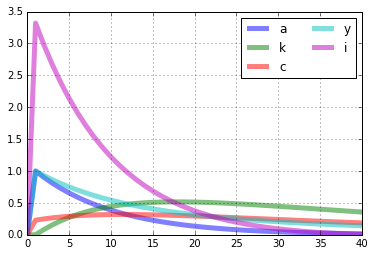

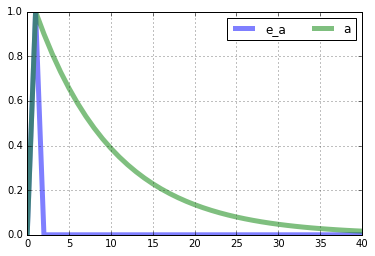

In [10]:
rbc.irs['e_a'][['a','k','c','y','i']].plot(lw='5',alpha=0.5,grid=True).legend(loc='upper right',ncol=2)
rbc.irs['e_a'][['e_a','a']].plot(lw='5',alpha=0.5,grid=True).legend(loc='upper right',ncol=2)

## Stochastic simulation

Creating a stochastic simulation of the model is straightforward with the `.stoch_sim()` method. In the following example, I create a 151 period (including t=0) simulation by first simulating the model for 251 periods and then dropping the first 100 values. The standard deviation of the shock to $A_t$ is set to 0.00763. The seed for the numpy random number generator is set to 0.

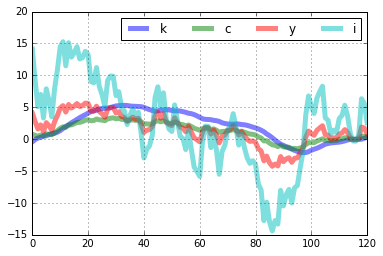

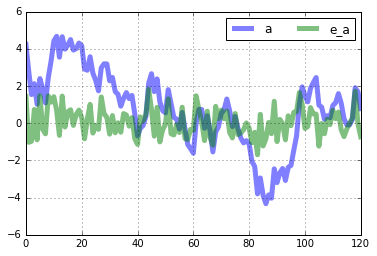

In [11]:
rbc.stoch_sim(T=121,drop_first=100,cov_mat=np.array([0.00763**2]),seed=0,percent=True)
rbc.simulated[['k','c','y','i']].plot(lw='5',alpha=0.5,grid=True).legend(loc='upper right',ncol=4)
rbc.simulated[['a']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=4)
rbc.simulated['e_a'].plot(lw='5',alpha=0.5,grid=True).legend(ncol=4)

## Example 3: A New-Keynesian Model

Consider the new-Keynesian business cycle model from Walsh (2017), chapter 8 expressed in log-linear terms:

\begin{align}
y_t & = E_ty_{t+1} - \sigma^{-1} (i_t - E_t\pi_{t+1}) + g_t\\
\pi_t & = \beta  E_t\pi_{t+1} + \kappa  y_t + u_t\\
i_t & = \phi_x  y_t + \phi_{\pi}  \pi_t + v_t\\
r_t & = i_t - E_t\pi_{t+1}\\
g_{t+1} & = \rho_g g_{t} + \epsilon_{t+1}^g\\
u_{t+1} & = \rho_u u_{t} + \epsilon_{t+1}^u\\
v_{t+1} & = \rho_v v_{t} + \epsilon_{t+1}^v
\end{align}

where $y_t$ is the output gap (log-deviation of output from the natural rate), $\pi_t$ is the quarterly rate of inflation between $t-1$ and $t$, $i_t$ is the nominal interest rate on funds moving between period $t$ and $t+1$, $r_t$ is the real interest rate, $g_t$ is the exogenous component of demand, $u_t$ is an exogenous component of inflation, and $v_t$ is the exogenous component of monetary policy.

Since the model is already log-linear, there is no need to approximate the equilibrium conditions. We'll still use the `.log_linear` method to find the matrices $A$ and $B$, but we'll have to set the `islinear` option to `True` to avoid generating an error.

### Inintialize model and solve

In [12]:
# Input model parameters
beta = 0.99
sigma= 1
eta  = 1
omega= 0.8
kappa= (sigma+eta)*(1-omega)*(1-beta*omega)/omega

rhor = 0.9
phipi= 1.5
phiy = 0

rhog = 0.5
rhou = 0.5
rhov = 0.9

Sigma = 0.001*np.eye(3)

# Store parameters
parameters = pd.Series({
    'beta':beta,
    'sigma':sigma,
    'eta':eta,
    'omega':omega,
    'kappa':kappa,
    'rhor':rhor,
    'phipi':phipi,
    'phiy':phiy,
    'rhog':rhog,
    'rhou':rhou,
    'rhov':rhov
})


# Define function that computes equilibrium conditions
def equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Exogenous demand
    g_proc =  p.rhog*cur.g - fwd.g
    
    # Exogenous inflation
    u_proc =  p.rhou*cur.u - fwd.u
    
    # Exogenous monetary policy
    v_proc =  p.rhov*cur.v - fwd.v
    
    # Euler equation
    euler_eqn = fwd.y -1/p.sigma*(cur.i-fwd.pi) + fwd.g - cur.y
    
    # NK Phillips curve evolution
    phillips_curve = p.beta*fwd.pi + p.kappa*cur.y + fwd.u - cur.pi
    
    # interest rate rule
    interest_rule = p.phiy*cur.y+p.phipi*cur.pi + fwd.v - cur.i
    
    # Fisher equation
    fisher_eqn = cur.i - fwd.pi - cur.r
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            g_proc,
            u_proc,
            v_proc,
            euler_eqn,
            phillips_curve,
            interest_rule,
            fisher_eqn
        ])

# Initialize the nk model
nk = ls.model(equations=equations,
              n_states=3,
              n_exo_states = 3,
              var_names=['g','u','v','i','r','y','pi'],
              parameters=parameters)

# Set the steady state of the nk model
nk.set_ss([0,0,0,0,0,0,0])

# Find the log-linear approximation around the non-stochastic steady state
nk.linear_approximation()

# Solve the nk model
nk.solve_klein(nk.a,nk.b)

### Compute impulse responses and plot

Compute impulse responses of the endogenous variables to a one percent shock to each exogenous variable.

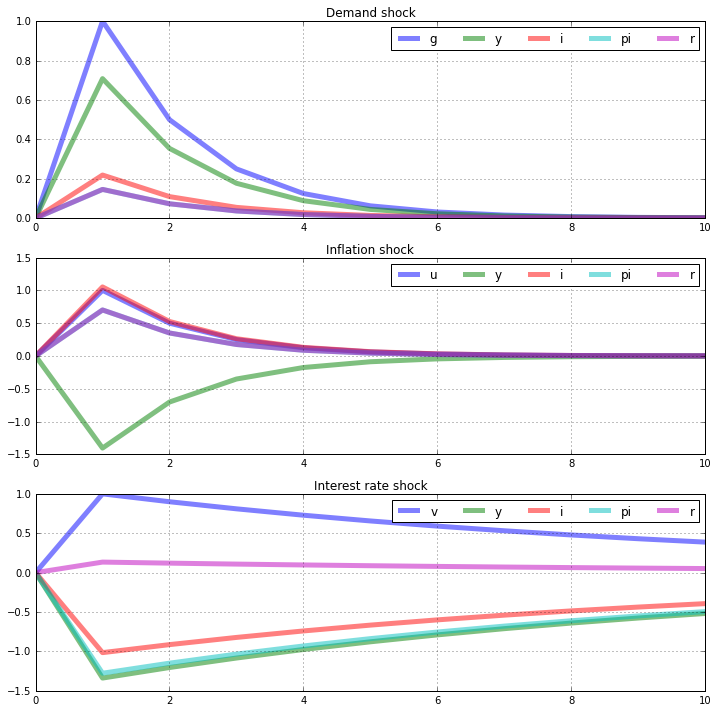

In [13]:
# Compute impulse responses
nk.impulse(T=11,t0=1,shocks=None)

# Create the figure and axes
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# Plot commands
nk.irs['e_g'][['g','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Demand shock',ax=ax1).legend(loc='upper right',ncol=5)
nk.irs['e_u'][['u','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Inflation shock',ax=ax2).legend(loc='upper right',ncol=5)
nk.irs['e_v'][['v','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Interest rate shock',ax=ax3).legend(loc='upper right',ncol=5)

### Construct a stochastic simulation and plot

Contruct a 151 period stochastic simulation by first siumlating the model for 251 periods and then dropping the first 100 values. The seed for the numpy random number generator is set to 0.

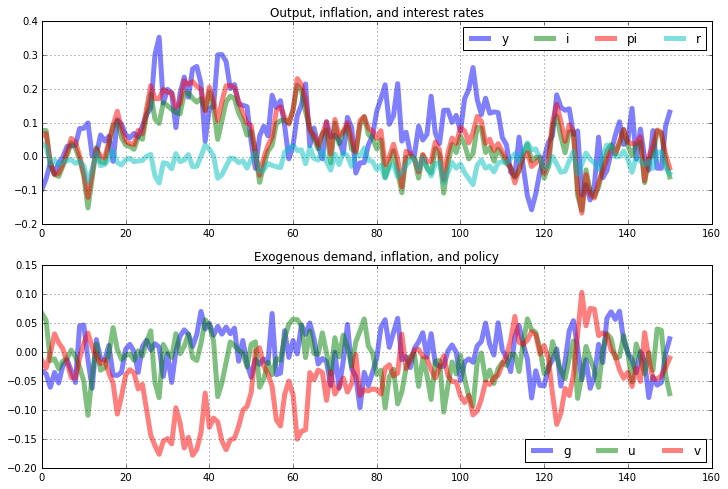

In [14]:
# Compute stochastic simulation
nk.stoch_sim(T=151,drop_first=100,cov_mat=Sigma,seed=0)

# Create the figure and axes
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

# Plot commands
nk.simulated[['y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Output, inflation, and interest rates',ax=ax1).legend(ncol=4)
nk.simulated[['g','u','v']].plot(lw='5',alpha=0.5,grid=True,title='Exogenous demand, inflation, and policy',ax=ax2).legend(ncol=4,loc='lower right')

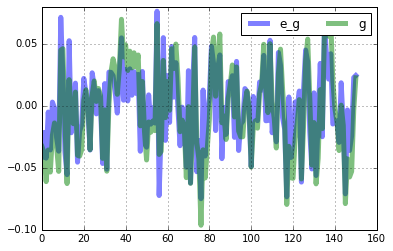

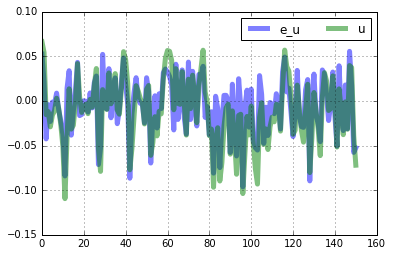

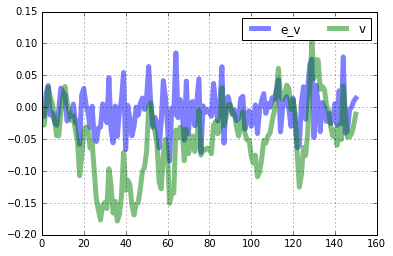

In [15]:
# Plot simulated exogenous shocks
nk.simulated[['e_g','g']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['e_u','u']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['e_v','v']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)